# [PetFinder.my - Pawpularity Contest](https://www.kaggle.com/c/petfinder-pawpularity-score)
> Predict the popularity of shelter pet photos

![](https://storage.googleapis.com/kaggle-competitions/kaggle/25383/logos/header.png)

# Idea:
* Basic idea of this notebook is to use only **Image** Feature.
* Tabular data will be merged on later Notebooks. 
* **Wandb** is integrated hence we can use this notebook to track which experiemnt is peforming better and also do error analysis using **Grad-CAM** at the end.


# Notebooks:
* train: [[TF] PetFinder: Image [TPU][Train] 🐶](https://www.kaggle.com/awsaf49/tf-petfinder-image-tpu-train)
* infer: [[TF] PetFinder: Image [TPU][Infer] 🐶](https://www.kaggle.com/awsaf49/tf-petfinder-image-tpu-infer)


# Overview:

## Augmentations:
* Random - Horizontal Flip
* Random - Brightness, Contrast, Hue, Saturation
* Coarse Dropout

<img src="https://i.ibb.co/XC4dBJs/results-39-0.png" alt="results-39-0" border="0">

## WandB Integration:
* You can track your training using **wandb**
* It's very easy to compare model's performance using **wandb**.

<img src="https://i.ibb.co/KKxF8Fj/wandb-result.png" alt="wandb-result" border="0">

## Grad-CAM:
* You can use **Grad-CAM** to interpret the results

<img src="https://i.ibb.co/WPwNcc9/wandb-grad-cam.png" alt="wandb-grad-cam" border="0">

## Train Vs OOF Distribution:

<img src="https://i.ibb.co/Yy4NXvW/results-58-0.png" alt="results-58-0" border="0">

# Content:
* Install Libraries.
* Import Libraries.
* Libraries Version Check
* Wandb
* Configuration.
* Set Seed for Reproducibility.
* TPU Configs.
* GCS Path for TPU.
* Meta Data.
* Train-Test Distrubution
* EDA
    * Train.
    * Test.
* Data Split.
* Data Augmentation.
* Data Pipeline.
* Visualization.
* Loss Function.
* Build Model.
* Learning-Rate Scheduler.
* Grad-CAM Helper
* Wandb Logger
* Train Model
* Calculate OOF Scorej
* Pawpularity Distrubtion of Train & OOF





# Install Libraries

In [1]:
!pip install -q efficientnet >> /dev/null
!pip install -q imagesize
!pip install -qU wandb

# Import Libraries

In [2]:
import pandas as pd, numpy as np, random,os, shutil
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
import sklearn
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import imagesize
import wandb
import yaml
from IPython import display as ipd

from glob import glob
from tqdm.notebook import tqdm
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score

2021-09-27 17:33:23.116971: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-27 17:33:23.117096: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Version Check

In [3]:
print('np:', np.__version__)
print('pd:', pd.__version__)
print('sklearn:', sklearn.__version__)
print('tf:',tf.__version__)
print('tfa:', tfa.__version__)
print('w&b:', wandb.__version__)

np: 1.19.5
pd: 1.3.2
sklearn: 0.23.2
tf: 2.4.1
tfa: 0.12.1
w&b: 0.12.2


# Wandb

<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

<span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;"> Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management</span>

<span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Some of the cool features of **W&B**:</span>

* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Track, compare, and visualize ML experiments<br></span>
* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Get live metrics, terminal logs, and system stats streamed to the centralized dashboard.<br></span>
* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Explain how your model works, show graphs of how model versions improved, discuss bugs, and demonstrate progress towards milestones.<br></span>

In [4]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Configuration

In [5]:
class CFG:
    wandb         = True
    competition   = 'petfinder' 
    _wandb_kernel = 'awsaf49'
    debug         = False
    exp_name      ='effnetb2-baseline' # name of the experiment, folds will be grouped using 'exp_name'
    
    # USE verbose=0 for silent, vebose=1 for interactive, verbose=2 for commit
    verbose      = 1 if debug else 0
    display_plot = True

    device = "TPU" #or "GPU"

    model_name = 'efficientnet_b2'

    # USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
    seed = 42

    # NUMBER OF FOLDS. USE 2, 5, 10
    folds = 5
    
    # FOLDS TO TRAIN
    selected_folds = [0, 1, 2, 3, 4]

    # IMAGE SIZE
    img_size = [512, 512]

    # BATCH SIZE AND EPOCHS
    batch_size  = 32
    epochs      = 12

    # LOSS
    loss      = 'RMSE'
    optimizer = 'Adam'

    # CFG.augmentATION
    augment   = True
    transform = False

    # TRANSFORMATION
    fill_mode = 'nearest'
    rot    = 10.0
    shr    = 5.0
    hzoom  = 30.0
    wzoom  = 30.0
    hshift = 30.0
    wshift = 30.0

    # FLIP
    hflip = True
    vflip = False

    # CLIP [0, 1]
    clip = False

    # LEARNING RATE SCHEDULER
    scheduler   = 'exp' # Cosine

    # Dropout
    drop_prob   = 0.75
    drop_cnt    = 10
    drop_size   = 0.05

    #bri, contrast
    sat  = [0.7, 1.3]
    cont = [0.8, 1.2]
    bri  =  0.15
    hue  = 0.05

    # TEST TIME CFG.augmentATION STEPS
    tta = 1
    
    tab_cols    = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
                   'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
    target_col  = ['Pawpularity']

# Set Seed for Reproducibility

In [6]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(CFG.seed)

seeding done!!!


# TPU Configs

In [7]:
if CFG.device == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        CFG.device = "GPU"

if CFG.device != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if CFG.device == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...


2021-09-27 17:33:32.599340: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-27 17:33:32.602223: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-27 17:33:32.602263: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-27 17:33:32.602288: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (aa75b0651c5f): /proc/driver/nvidia/version does not exist
2021-09-27 17:33:32.605750: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

TPU initialized
REPLICAS: 8


# GCS Path for TPU
* TPU requires **GCS** path. Luckily Kaggle Provides that for us :)

In [8]:
BASE_PATH = '/kaggle/input/petfinder-pawpularity-score'
GCS_PATH  = KaggleDatasets().get_gcs_path('petfinder-pawpularity-score')

# Meta Data

In [9]:
def get_imgsize(row):
    width, height = imagesize.get(row['image_path'].replace(GCS_PATH, BASE_PATH))
    row['width']  = width
    row['height'] = height
    return row

In [10]:
# Train Data
df = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
df['image_path'] = GCS_PATH + '/train/' + df.Id + '.jpg'
tqdm.pandas(desc='train')
df = df.progress_apply(get_imgsize, axis=1)
display(df.head(2))

# Test Data
test_df  = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
test_df['image_path'] = GCS_PATH + '/test/' + test_df.Id + '.jpg'
tqdm.pandas(desc='test')
test_df = test_df.progress_apply(get_imgsize, axis=1)

display(test_df.head(2))

train:   0%|          | 0/9912 [00:00<?, ?it/s]

Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   

                                          image_path  width  height  
0  gs://kds-e9b8357c705656cf67af24a9b30e17b096e3d...    405     720  
1  gs://kds-e9b8357c705656cf67af24a9b30e17b096e3d...   1032     774

test:   0%|          | 0/8 [00:00<?, ?it/s]

Id  Subject Focus  Eyes  Face  Near  Action  \
0  4128bae22183829d2b5fea10effdb0c3              1     0     1     0       0   
1  43a2262d7738e3d420d453815151079e              0     1     0     0       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
0          1      1        0      0          1     0     1   
1          0      1        1      0          0     0     0   

                                          image_path  width  height  
0  gs://kds-e9b8357c705656cf67af24a9b30e17b096e3d...    128     128  
1  gs://kds-e9b8357c705656cf67af24a9b30e17b096e3d...    128     128

## Train-Test Ditribution

In [11]:
print('train_files:',df.shape[0])
print('test_files:',test_df.shape[0])

train_files: 9912
test_files: 8


# Light EDA
If you're too lazy to do **EDA** by yourself. Then definitely this library is for you. You can use **Pandas-Profiling** to do bunch of **EDA** with vey few lines of code. 😉

In [12]:
from pandas_profiling import ProfileReport
train_profile = ProfileReport(df, title="Train Data")
test_profile  = ProfileReport(test_df, title="Test Data")

## Train

In [13]:
display(train_profile)

Summarize dataset:   0%|          | 0/30 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Test

In [14]:
display(test_profile)

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Data Split
* Data is splited using **Pawpularity** distrubtion.


In [15]:
num_bins = int(np.floor(1 + np.log2(len(df))))
df["bins"] = pd.cut(df[CFG.target_col].values.reshape(-1), bins=num_bins, labels=False)

skf = StratifiedKFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df["bins"])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold', "bins"]).size())

fold  bins
0.0   0        66
      1        84
      2       221
      3       406
      4       376
             ... 
4.0   9        55
      10       40
      11       28
      12       21
      13       72
Length: 70, dtype: int64

# Data Augmentation
Used simple augmentations, some of them may hurt the model.
* RandomFlip (Left-Right)
* No Rotation
* RandomBrightness
* RndomContrast
* Shear
* Zoom
* Coarsee Dropout/Cutout

In [16]:
def get_mat(shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    #rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
#     c1   = tf.math.cos(rotation)
#     s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
#     rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
#                                    -s1,  c1,   zero, 
#                                    zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                               zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    

    return  K.dot(shear_matrix,K.dot(zoom_matrix, shift_matrix)) #K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))                  

def transform(image, DIM=CFG.img_size):#[rot,shr,h_zoom,w_zoom,h_shift,w_shift]):
    if DIM[0]!=DIM[1]:
        pad = (DIM[0]-DIM[1])//2
        image = tf.pad(image, [[0, 0], [pad, pad+1],[0, 0]])
        
    NEW_DIM = DIM[0]
    
    rot = CFG.rot * tf.random.normal([1], dtype='float32')
    shr = CFG.shr * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / CFG.hzoom
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / CFG.wzoom
    h_shift = CFG.hshift * tf.random.normal([1], dtype='float32') 
    w_shift = CFG.wshift * tf.random.normal([1], dtype='float32') 
    
    transformation_matrix=tf.linalg.inv(get_mat(shr,h_zoom,w_zoom,h_shift,w_shift))
    
    flat_tensor=tfa.image.transform_ops.matrices_to_flat_transforms(transformation_matrix)
    
    image=tfa.image.transform(image,flat_tensor, fill_mode=CFG.fill_mode)
    
    rotation = math.pi * rot / 180.
    
    image=tfa.image.rotate(image,-rotation, fill_mode=CFG.fill_mode)
    
    if DIM[0]!=DIM[1]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,3])
        image = image[:, pad:DIM[1]+pad,:]
    image = tf.reshape(image, [*DIM, 3])    
    return image

def dropout(image,DIM=CFG.img_size, PROBABILITY = 0.6, CT = 5, SZ = 0.1):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed
    
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): 
        return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM[1]),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM[0]),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*min(DIM),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM[0],y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM[1],x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3], dtype = image.dtype) 
        three = image[ya:yb,xb:DIM[1],:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM[0],:,:]],axis=0)
        image = tf.reshape(image,[*DIM,3])

#     image = tf.reshape(image,[*DIM,3])
    return image

## Data Pipeline
* Reads the raw file and then decodes it to tf.Tensor
* Resizes the image in desired size
* Chages the datatype to **float32**
* Caches the Data for boosting up the speed.
* Uses Augmentations to reduce overfitting and make model more robust.
* Finally, splits the data into batches.


In [17]:
def build_decoder(with_labels=True, target_size=CFG.img_size, ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.image.resize(img, target_size)
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.reshape(img, [*target_size, 3])

        return img
    
    def decode_with_labels(path, label):
        return decode(path), tf.cast(label, tf.float32)
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True, dim=CFG.img_size):
    def augment(img, dim=dim):
        img = transform(img,DIM=dim) if CFG.transform else img
        img = tf.image.random_flip_left_right(img) if CFG.hflip else img
        img = tf.image.random_flip_up_down(img) if CFG.vflip else img
        img = tf.image.random_hue(img, CFG.hue)
        img = tf.image.random_saturation(img, CFG.sat[0], CFG.sat[1])
        img = tf.image.random_contrast(img, CFG.cont[0], CFG.cont[1])
        img = tf.image.random_brightness(img, CFG.bri)
        img = dropout(img, DIM=dim, PROBABILITY = CFG.drop_prob, CT = CFG.drop_cnt, SZ = CFG.drop_size)
        img = tf.clip_by_value(img, 0, 1)  if CFG.clip else img         
        img = tf.reshape(img, [*dim, 3])
        return img
    
    def augment_with_labels(img, label):    
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(AUTO)
    return ds

## Visualization
* Check if augmentation is working properly or not.

In [18]:
def display_batch(batch, size=2):
    imgs, tars = batch
    plt.figure(figsize=(size*5, 5))
    for img_idx in range(size):
        plt.subplot(1, size, img_idx+1)
        plt.title(f'{CFG.target_col[0]}: {tars[img_idx].numpy()[0]}', fontsize=15)
        plt.imshow(imgs[img_idx,:, :, :])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show() 

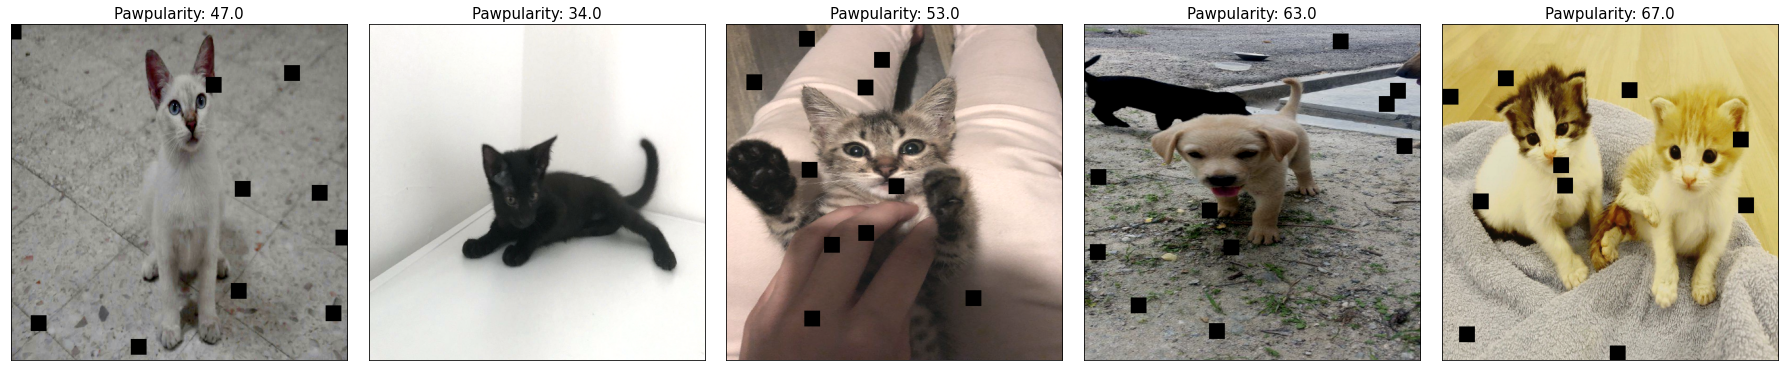

In [19]:
fold = 0
fold_df = df.query('fold==@fold')[:1000]
paths  = fold_df.image_path.tolist()
labels = fold_df[CFG.target_col].values
ds = build_dataset(paths, labels, cache=False, batch_size=CFG.batch_size*REPLICAS,
                   repeat=True, shuffle=True, augment=True)
ds = ds.unbatch().batch(20)
batch = next(iter(ds))
display_batch(batch, 5);

# Loss Function
Loss Function for this competition is **RMSE: Root Mean Squared Error**
$$\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

where $\hat{y}_i$ is the **predicted** value and $y_i$ is the **original** value for each instance $i$. Check out this blog, [What does RMSE really mean?](https://towardsdatascience.com/what-does-rmse-really-mean-806b65f2e48e) for more details

In [20]:
def RMSE(y_true, y_pred):
    loss = tf.math.sqrt(tf.math.reduce_mean(tf.math.square(tf.subtract(y_true, y_pred))))
    return loss

# Build Model


In [21]:
import efficientnet.tfkeras as efn

name2effnet = {
    'efficientnet_b0': efn.EfficientNetB0,
    'efficientnet_b1': efn.EfficientNetB1,
    'efficientnet_b2': efn.EfficientNetB2,
    'efficientnet_b3': efn.EfficientNetB3,
    'efficientnet_b4': efn.EfficientNetB4,
    'efficientnet_b5': efn.EfficientNetB5,
    'efficientnet_b6': efn.EfficientNetB6,
    'efficientnet_b7': efn.EfficientNetB7,
}

def build_model(model_name=CFG.model_name, DIM=CFG.img_size[0], compile_model=True, include_top=False):       
    base = name2effnet[model_name](input_shape=(DIM, DIM, 3),
                                  include_top=include_top,
                                   weights='imagenet',
                                  )
    inp = base.inputs
    out = base.output
    out = tf.keras.layers.GlobalAveragePooling2D()(out)
    out = tf.keras.layers.Dense(64,activation='selu')(out)
    out = tf.keras.layers.Dense(1)(out)
    model = tf.keras.Model(inputs=inp, outputs=out)
    if compile_model:
        #optimizer
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        #loss
        loss = RMSE
        #metric
        rmse = tf.keras.metrics.RootMeanSquaredError(name='rmse')
        model.compile(optimizer=opt,
                      loss=loss,
                      metrics=[rmse])
    return model

## Model Check

In [22]:
tmp = build_model(CFG.model_name, DIM=CFG.img_size[0], compile_model=True)

31940608/31936256 [==============================] - 0s 0us/step


# Learning-Rate Scheduler

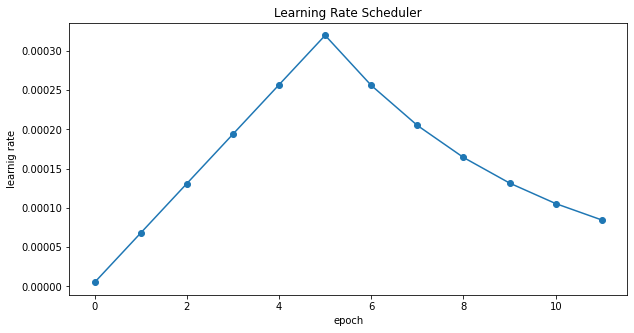

In [23]:
def get_lr_callback(batch_size=8, plot=False):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        elif CFG.scheduler=='exp':
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        elif CFG.scheduler=='cosine':
            decay_total_epochs = CFG.epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            cosine_decay = 0.5 * (1 + math.cos(phase))
            lr = (lr_max - lr_min) * cosine_decay + lr_min
        return lr
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(CFG.epochs), [lrfn(epoch) for epoch in np.arange(CFG.epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

_=get_lr_callback(CFG.batch_size, plot=True )

# Grad-CAM
Gradient-weighted Class Activation Mapping (Grad-CAM), uses the class-specific gradient information flowing into the final convolutional layer of a CNN to produce a coarse localization map of the important regions in the image. Grad-CAM is a strict generalization of the Class Activation Mapping. Grad-CAM provides visual explanations to better understand image classification problems.

<img src="http://gradcam.cloudcv.org/static/images/network.png" width="800">

In [24]:
import matplotlib.cm as cm, cv2
from tensorflow import keras

def gen_gradcam_heatmap(img, model, last_conv_layer_name='top_conv', pred_index=0):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer('top_conv').output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def get_gradcam(img, model,  alpha=0.4, show=False):

    heatmap = gen_gradcam_heatmap(img, model, last_conv_layer_name='top_conv', pred_index=0)
    img     = img[0]
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors  = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = cv2.resize(jet_heatmap, dsize=(img.shape[1], img.shape[0]))

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
#     superimposed_img = np.uint8(superimposed_img*255.0)

    # Display Grad CAM
    if show:
        plt.imshow(superimposed_img)
        
    return superimposed_img

# **Wandb** Logger
Log:
* Best Score
* Grad-CAM

In [25]:
if CFG.wandb:
    def wandb_init(fold):
        config = {k:v for k,v in dict(vars(CFG)).items() if '__' not in k}
        yaml.dump(config, open(f'/kaggle/working/config fold-{fold}.yaml', 'w'),)
        config = yaml.load(open(f'/kaggle/working/config fold-{fold}.yaml', 'r'), Loader=yaml.FullLoader)
        run    = wandb.init(project="petfinder-public",
                   name=f"fold-{fold}|dim-{CFG.img_size[0]}|model-{CFG.model_name}",
                   config=config,
                   anonymous=anonymous,
                   group=CFG.exp_name
                        )
        return run
    
def log_wandb(fold):
    "log best result and grad-cam for error analysis"
    
    valid_df = df.loc[df.fold==fold].copy()
    valid_df['pred'] = oof_pred[fold].reshape(-1)
    valid_df['diff'] =  abs(valid_df.Pawpularity - valid_df.pred)
    valid_df    = valid_df[valid_df.fold == fold].reset_index(drop=True)
    vali_df     = valid_df.sort_values(by='diff', ascending=False)
    
    noimg_cols  = ['Id', 'fold', 'Subject Focus','Eyes','Face','Near','Action','Accessory','Group',
                    'Collage','Human','Occlusion','Info','Blur',
                   'Pawpularity', 'pred', 'diff']
    # select top and worst 10 cases
    gradcam_df  = pd.concat((valid_df.head(10), valid_df.tail(10)), axis=0)
    gradcam_ds  = build_dataset(gradcam_df.image_path, labels=None, cache=False, batch_size=1,
                   repeat=False, shuffle=False, augment=False)
    data = []
    for idx, img in enumerate(gradcam_ds):
        gradcam = get_gradcam(img, model)
        row = gradcam_df[noimg_cols].iloc[idx].tolist()
        data+=[[*row, wandb.Image(img.numpy()[0]), wandb.Image(gradcam)]]
    wandb_table = wandb.Table(data=data, columns=[*noimg_cols,'image', 'gradcam'])
    wandb.log({'best_rmse':oof_val[-1], 
               'best_rmse_tta':rmse,
               'best_epoch':np.argmin(history.history['val_rmse']),
               'viz_table':wandb_table})

# Train Model
* Cross-Validation: 5 fold
* **WandB** dashboard is shown end of the each fold. So we don't need to plot anything. We can select best model from here.

In [26]:
oof_pred = []; oof_tar = []; oof_val = []; oof_ids = []; oof_folds = []
preds = np.zeros((test_df.shape[0],1))

for fold in np.arange(CFG.folds):
    if fold not in CFG.selected_folds:
        continue
    if CFG.wandb:
        run = wandb_init(fold)
        WandbCallback = wandb.keras.WandbCallback(save_model=False)
    if CFG.device=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
            
    # TRAIN AND VALID DATAFRAME
    train_df = df.query("fold!=@fold")
    valid_df = df.query("fold==@fold")
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    train_paths = train_df.image_path.values; train_labels = train_df[CFG.target_col].values.astype(np.float32)
    valid_paths = valid_df.image_path.values;   valid_labels   = valid_df[CFG.target_col].values.astype(np.float32)
    test_paths  = test_df.image_path.values
    
    # SHUFFLE IMAGE AND LABELS
    index = np.arange(len(train_paths))
    np.random.shuffle(index)
    train_paths  = train_paths[index]
    train_labels = train_labels[index]
    
    if CFG.debug:
        train_paths = train_paths[:2000]; train_labels = train_labels[:2000]
        valid_paths = valid_paths[:1000]; valid_labels = valid_labels[:1000]
    
    print('#'*25); print('#### FOLD',fold)
    print('#### IMAGE_SIZE: (%i, %i) | MODEL_NAME: %s | BATCH_SIZE: %i'%
          (CFG.img_size[0],CFG.img_size[1],CFG.model_name,CFG.batch_size*REPLICAS))
    train_images = len(train_paths)
    val_images   = len(valid_paths)
    if CFG.wandb:
        wandb.log({'num_train':train_images,
                   'num_valid':val_images})
    print('#### NUM_TRAIN %i | NUM_VALID: %i'%(train_images, val_images))
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model(CFG.model_name, DIM=CFG.img_size[0], compile_model=True)

    # DATASET
    train_ds = build_dataset(train_paths, train_labels, cache=True, batch_size=CFG.batch_size*REPLICAS,
                   repeat=True, shuffle=True, augment=CFG.augment)
    val_ds   = build_dataset(valid_paths, valid_labels, cache=True, batch_size=CFG.batch_size*REPLICAS,
                   repeat=False, shuffle=False, augment=False)
    
    print('#'*25)   
    # SAVE BEST MODEL EACH FOLD
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_rmse', verbose=CFG.verbose, save_best_only=True,
        save_weights_only=False, mode='min', save_freq='epoch')
    callbacks = [sv,get_lr_callback(CFG.batch_size)]
    if CFG.wandb:
        callbacks.append(WandbCallback)
    # TRAIN
    print('Training...')
    history = model.fit(
        train_ds, 
        epochs=CFG.epochs if not CFG.debug else 2, 
        callbacks = callbacks, 
        steps_per_epoch=len(train_paths)/CFG.batch_size//REPLICAS,
        validation_data=val_ds, 
        #class_weight = {0:1,1:2},
        verbose=CFG.verbose
    )
    
    # Loading best model for inference
    print('Loading best model...')
    model.load_weights('fold-%i.h5'%fold)  
    
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...')
    ds_valid = build_dataset(valid_paths, labels=None, cache=False, batch_size=CFG.batch_size*REPLICAS*2,
                   repeat=True, shuffle=False, augment=True if CFG.tta>1 else False)
    ct_valid = len(valid_paths); STEPS = CFG.tta * ct_valid/CFG.batch_size/2/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=CFG.verbose)[:CFG.tta*ct_valid,] 
    oof_pred.append(np.mean(pred.reshape((ct_valid,-1,CFG.tta),order='F'),axis=-1) )                 
    
    # GET OOF TARGETS AND idS
    oof_tar.append(valid_df[CFG.target_col].values[:(1000 if CFG.debug else len(valid_df))])
    oof_folds.append(np.ones_like(oof_tar[-1],dtype='int8')*fold )
    oof_ids.append(valid_df.Id.values)
    
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = build_dataset(test_paths, labels=None, cache=True, 
                    batch_size=(CFG.batch_size*2 if len(test_df)>8 else 1)*REPLICAS,
                   repeat=True, shuffle=False, augment=True if CFG.tta>1 else False)
    ct_test = len(test_paths); STEPS = 1 if len(test_df)<=8 else (CFG.tta * ct_test/CFG.batch_size/2/REPLICAS)
    pred = model.predict(ds_test,steps=STEPS,verbose=CFG.verbose)[:CFG.tta*ct_test,] 
    preds[:ct_test, :] += np.mean(pred.reshape((ct_test,-1,CFG.tta),order='F'),axis=-1) / CFG.folds # not meaningful for DIBUG = True
    
    # REPORT RESULTS
    y_true =oof_tar[-1]; y_pred = oof_pred[-1]
    rmse   =RMSE(y_true.astype(np.float32),y_pred).numpy()
    oof_val.append(np.min( history.history['val_rmse'] ))
    print('#### FOLD %i OOF RMSE without TTA = %.3f, with TTA = %.3f'%(fold,oof_val[-1],rmse))
    
    if CFG.wandb:
        log_wandb(fold) # log result to wandb
        wandb.run.finish() # finish the run
        display(ipd.IFrame(run.url, width=1080, height=720)) # show wandb dashboard

wandb: Currently logged in as: awsaf49 (use `wandb login --relogin` to force relogin)
2021-09-27 17:36:19.072997: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-27 17:36:19.073713: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



#########################
#### FOLD 0
#### IMAGE_SIZE: (512, 512) | MODEL_NAME: efficientnet_b2 | BATCH_SIZE: 256
#### NUM_TRAIN 7929 | NUM_VALID: 1983
#########################
Training...
Loading best model...
Predicting OOF with TTA...
Predicting Test with TTA...
#### FOLD 0 OOF RMSE without TTA = 19.046, with TTA = 19.054


2021-09-27 17:49:40.451598: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 158530, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1632764980.448149574","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 158530, Output num: 0","grpc_status":3}


2021-09-27 17:50:03.982826: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-27 17:50:03.983199: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



#########################
#### FOLD 1
#### IMAGE_SIZE: (512, 512) | MODEL_NAME: efficientnet_b2 | BATCH_SIZE: 256
#### NUM_TRAIN 7929 | NUM_VALID: 1983
#########################
Training...
Loading best model...
Predicting OOF with TTA...
Predicting Test with TTA...
#### FOLD 1 OOF RMSE without TTA = 19.468, with TTA = 19.472


2021-09-27 18:02:09.103993: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 314034, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1632765729.103885727","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 314034, Output num: 0","grpc_status":3}


2021-09-27 18:02:22.096583: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-27 18:02:22.096643: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



#########################
#### FOLD 2
#### IMAGE_SIZE: (512, 512) | MODEL_NAME: efficientnet_b2 | BATCH_SIZE: 256
#### NUM_TRAIN 7930 | NUM_VALID: 1982
#########################
Training...
Loading best model...
Predicting OOF with TTA...
Predicting Test with TTA...
#### FOLD 2 OOF RMSE without TTA = 19.337, with TTA = 19.339


2021-09-27 18:14:24.655162: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 478018, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1632766464.655022034","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 478018, Output num: 0","grpc_status":3}


2021-09-27 18:14:40.409142: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-27 18:14:40.409199: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



#########################
#### FOLD 3
#### IMAGE_SIZE: (512, 512) | MODEL_NAME: efficientnet_b2 | BATCH_SIZE: 256
#### NUM_TRAIN 7930 | NUM_VALID: 1982
#########################
Training...
Loading best model...
Predicting OOF with TTA...
Predicting Test with TTA...
#### FOLD 3 OOF RMSE without TTA = 18.539, with TTA = 18.525


2021-09-27 18:28:12.353567: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 642002, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1632767292.353395446","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 642002, Output num: 0","grpc_status":3}


2021-09-27 18:28:24.907678: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-27 18:28:24.907734: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



#########################
#### FOLD 4
#### IMAGE_SIZE: (512, 512) | MODEL_NAME: efficientnet_b2 | BATCH_SIZE: 256
#### NUM_TRAIN 7930 | NUM_VALID: 1982
#########################
Training...
Loading best model...
Predicting OOF with TTA...
Predicting Test with TTA...
#### FOLD 4 OOF RMSE without TTA = 18.889, with TTA = 18.885


2021-09-27 18:40:48.946002: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 819778, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1632768048.945822075","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 819778, Output num: 0","grpc_status":3}


# Calculate OOF Score

In [27]:
# COMPUTE OVERALL OOF RMSE
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
ids = np.concatenate(oof_ids); folds = np.concatenate(oof_folds)
rmse = RMSE(true.astype(np.float32),oof)
print('Overall OOF RMSE with TTA = %.3f'%rmse)

Overall OOF RMSE with TTA = 19.058


In [28]:
# SAVE OOF TO DISK
columns = ['Id', 'fold', 'true', 'pred']
df_oof = pd.DataFrame(np.concatenate([ids[:,None], folds[:, 0:1], true, oof], axis=1), columns=columns)
df_oof.to_csv('oof.csv',index=False)
df_oof.head()

Id fold true       pred
0  0007de18844b0dbbb5e1f607da0606e0    0   63  37.888264
1  0013fd999caf9a3efe1352ca1b0d937e    0   28  55.244167
2  00630b1262efe301cb15a3b2022ba744    0   18  37.159351
3  0067aaaa500b530c76b9c91af34b4cb8    0   98  67.069382
4  006cda7fec46a527f9f627f4722a2304    0   34  36.295437

# Pawpularity Distribution of OOF & Train 
Check **Pawpularity** distribution of `train` and `oof`. 

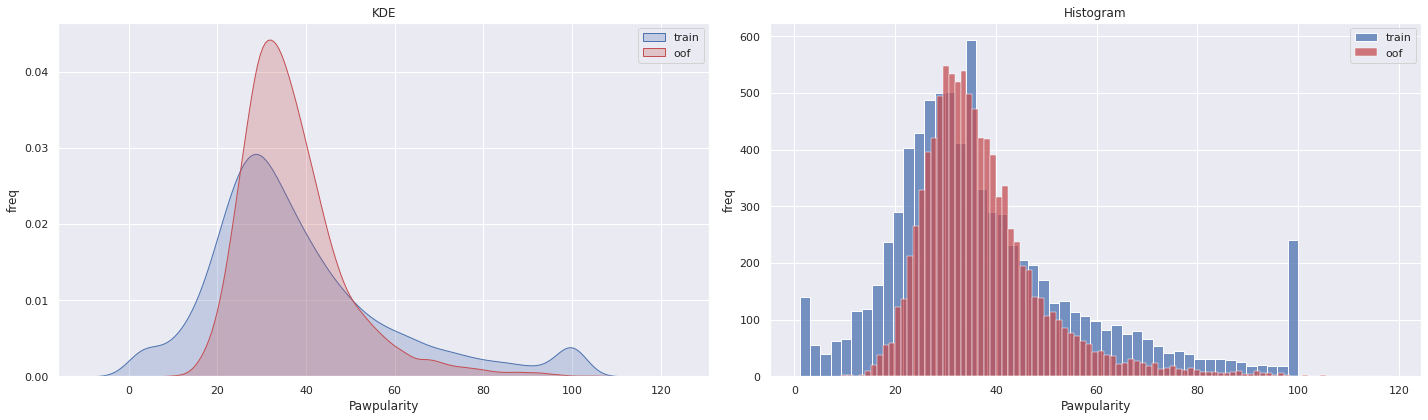

In [29]:
import seaborn as sns
sns.set(style='dark')

plt.figure(figsize=(10*2,6))

plt.subplot(1, 2, 1)
sns.kdeplot(x=train_df[CFG.target_col[0]], color='b',shade=True);
sns.kdeplot(x=df_oof.pred.values, color='r',shade=True);
plt.grid('ON')
plt.xlabel(CFG.target_col[0]);plt.ylabel('freq');plt.title('KDE')
plt.legend(['train', 'oof'])

plt.subplot(1, 2, 2)
sns.histplot(x=train_df[CFG.target_col[0]], color='b');
sns.histplot(x=df_oof.pred.values, color='r');
plt.grid('ON')
plt.xlabel(CFG.target_col[0]);plt.ylabel('freq');plt.title('Histogram')
plt.legend(['train', 'oof'])

plt.tight_layout()
plt.show()

# Submission
This notebook can't be used for submission as this noteboook uses **TPU** which requires `internet access`.

In [30]:
pred_df = pd.DataFrame({'Id':test_df.Id,
                        'Pawpularity':preds.reshape(-1)})
sub_df = pd.read_csv('/kaggle/input/petfinder-pawpularity-score/sample_submission.csv')
del sub_df['Pawpularity']
sub_df = sub_df.merge(pred_df, on='Id', how='left')
sub_df.to_csv('submission.csv',index=False)
sub_df.head(2)

Id  Pawpularity
0  4128bae22183829d2b5fea10effdb0c3     0.010137
1  43a2262d7738e3d420d453815151079e     0.083995

# Remove Files

In [31]:
!rm -r /kaggle/working/wandb